In [113]:
# Fix imports when running from notebooks/ folder
import sys
from pathlib import Path

project_root = Path.cwd().parent 
if str(project_root) not in sys.path:
    sys.path.insert(0, str(project_root))

print(f"Added to path: {project_root}")

%load_ext autoreload
%autoreload 2

Added to path: /Users/elshaday/DEV/10Academy/credit-risk-probability-week4
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Recency, Frequency, and Monetary (RFM) for each customer

In [114]:
from src import DataManager
import pandas as pd
from scripts.constants import Columns, PROCESSED_FEATURES_WITH_PROXY_VAR_DATA_FILE_NAME, PROCESSED_FEATURES_DATA_FILE_NAME
from tabulate import tabulate
from sklearn.preprocessing import RobustScaler
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import numpy as np

In [115]:
dm = DataManager()
raw_df = dm.load_csv()


Loading ../data/raw/raw_data.csv...
Sucessfully loaded ../data/raw/raw_data.csv!


In [116]:
# Step 1: Recency: Number of days between a fixed snapshot date (one day after the last transaction) and customer’s most recent transaction
# Interpretation: Lower Recency = more recent activity = lower risk and Higher Recency = long inactivity = higher risk


# Parse date column
raw_df[Columns.TransactionStartTime.value] = pd.to_datetime(
    raw_df[Columns.TransactionStartTime.value], errors="coerce", utc=True
)
raw_df[Columns.TransactionStartTime.value].dtype

# Snapshot Date
last_transaction_time = raw_df[Columns.TransactionStartTime.value].max()
snapshot_date = last_transaction_time + pd.Timedelta(days=1)

# Most recent transaction
print("Take most recent transaction time for each customer:")
rfm_df = (
    raw_df.groupby(Columns.CustomerId.value)
    .agg(
        MostRecentTransactionStartTime=(
            Columns.TransactionStartTime.value,
            "max",
        ),
        Frequency=(Columns.TransactionId.value, "count"),
        Monetary=(Columns.Amount.value, "sum"),
    )
    .reset_index()
)

rfm_df["Recency"] = (snapshot_date - rfm_df["MostRecentTransactionStartTime"]).dt.days

# Remove MostRecentTransactionStartTime
rfm_df.drop(columns=["MostRecentTransactionStartTime"], inplace=True)

rfm_df["Monetary"] = rfm_df["Monetary"].fillna(0)
# Clip negatives (refunds) to 0
rfm_df["Monetary"] = rfm_df["Monetary"].clip(lower=0)  # no positive spending
# Log transform
rfm_df["Monetary"] = np.log1p(rfm_df["Monetary"])  


print(tabulate(rfm_df.head(), headers="keys", tablefmt="grid"))
print(
    f"\nSnapshot Date (One Day After Most Recent Transaction in DataSet): {snapshot_date}"
)

Take most recent transaction time for each customer:
+----+-----------------+-------------+------------+-----------+
|    | CustomerId      |   Frequency |   Monetary |   Recency |
+====+=================+=============+============+===========+
|  0 | CustomerId_1    |           1 |    0       |        84 |
+----+-----------------+-------------+------------+-----------+
|  1 | CustomerId_10   |           1 |    0       |        84 |
+----+-----------------+-------------+------------+-----------+
|  2 | CustomerId_1001 |           5 |    9.90354 |        90 |
+----+-----------------+-------------+------------+-----------+
|  3 | CustomerId_1002 |          11 |    8.34901 |        26 |
+----+-----------------+-------------+------------+-----------+
|  4 | CustomerId_1003 |           6 |    9.90354 |        12 |
+----+-----------------+-------------+------------+-----------+

Snapshot Date (One Day After Most Recent Transaction in DataSet): 2019-02-14 10:01:28+00:00


In [117]:
print("Data understanding:")
print(tabulate(rfm_df.describe(), headers="keys", tablefmt="grid"))

print("\nScaled RFM values before clustering:")

rfm_features = ["Frequency", "Monetary", "Recency"]
scaler = RobustScaler()
rfm_scaled = scaler.fit_transform(rfm_df[rfm_features])
rfm_scaled_df = pd.DataFrame(rfm_scaled, columns=rfm_features, index=rfm_df.index)


print(tabulate(rfm_scaled_df.head(), headers="keys", tablefmt="grid"))

Data understanding:
+-------+-------------+------------+-----------+
|       |   Frequency |   Monetary |   Recency |
+=======+=============+============+===========+
| count |   3742      | 3742       | 3742      |
+-------+-------------+------------+-----------+
| mean  |     25.5644 |    9.48054 |   31.4613 |
+-------+-------------+------------+-----------+
| std   |     96.9296 |    2.96024 |   27.1189 |
+-------+-------------+------------+-----------+
| min   |      1      |    0       |    1      |
+-------+-------------+------------+-----------+
| 25%   |      2      |    8.31346 |    6      |
+-------+-------------+------------+-----------+
| 50%   |      7      |    9.90354 |   25      |
+-------+-------------+------------+-----------+
| 75%   |     20      |   11.2894  |   54      |
+-------+-------------+------------+-----------+
| max   |   4091      |   18.2398  |   91      |
+-------+-------------+------------+-----------+

Scaled RFM values before clustering:
+----+-----

### Visualization

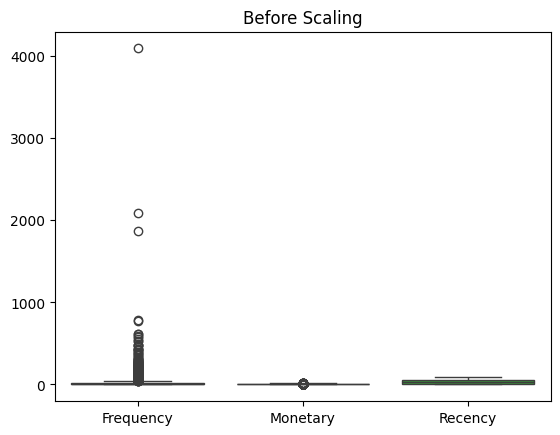

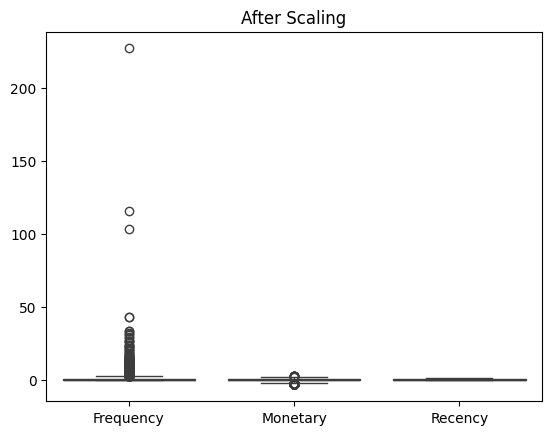

In [118]:
# Before scaling
sns.boxplot(data=rfm_df)
plt.title("Before Scaling")
plt.show()

# After scaling
sns.boxplot(data=rfm_scaled_df)
plt.title("After Scaling")
plt.show()

In [119]:
# K-Means Clustering

kmeans = KMeans(n_clusters=3, random_state=42)
rfm_df["ClusterLabel"] = kmeans.fit_predict(rfm_scaled_df)

print("\nCluster Distribution:")
print(rfm_df["ClusterLabel"].value_counts())


Cluster Distribution:
ClusterLabel
0    3686
2      55
1       1
Name: count, dtype: int64


In [120]:
print("Analyzing cluster results")
rfm_df.groupby("ClusterLabel")[["Recency", "Frequency", "Monetary"]].mean()

Analyzing cluster results


,Recency,Frequency,Monetary
ClusterLabel,,,
0,31.798698,18.414813,9.419154
1,29.000000,4091.000000,0.000000
2,8.890909,430.800000,13.767102


### Cluster-by-cluster analysis

| Metric        | Direction | Interpretation                                    |
| ------------- | --------- | ------------------------------------------------- |
| **Recency**   | ↑ worse   | Higher = longer since last activity = higher risk |
| **Frequency** | ↓ worse   | Lower = fewer transactions = higher risk          |
| **Monetary**  | ↓ worse   | Lower = less spending = higher risk               |


#### Breakdown
High Risk Customers = High Recency + Low Frequency + Low Monetary

**Cluster 0: High Risk**
- Highest Recency 
- Lowest Frequency 
- Moderate Monetary 

**Cluster 1: Neutral Users**
- High Recency
- Very High Frequency
- Lowest Monetary

**Cluster 2: Low Risk (Best Customers)**
- Lowest Recency
- High Frequency
- Highest Monetary

#### Verdict
| Cluster       | Risk Level          |
| ------------- | ------------------- |
| **Cluster 0** | High Risk           |
| **Cluster 1** | Medium / Neutral    |
| **Cluster 2** | Low Risk            |


In [121]:
print("Assign the High-Risk Label")

high_risk_cluster = 0

rfm_df["is_high_risk"] = (rfm_df["ClusterLabel"] == high_risk_cluster).astype(int)

print("\nAfter Assigning Is High Risk Label:")
print(tabulate(rfm_df.head(), headers="keys", tablefmt="grid"))

print("\nHigh Risk Distribution:")
print(rfm_df["is_high_risk"].value_counts())

Assign the High-Risk Label

After Assigning Is High Risk Label:
+----+-----------------+-------------+------------+-----------+----------------+----------------+
|    | CustomerId      |   Frequency |   Monetary |   Recency |   ClusterLabel |   is_high_risk |
+====+=================+=============+============+===========+================+================+
|  0 | CustomerId_1    |           1 |    0       |        84 |              0 |              1 |
+----+-----------------+-------------+------------+-----------+----------------+----------------+
|  1 | CustomerId_10   |           1 |    0       |        84 |              0 |              1 |
+----+-----------------+-------------+------------+-----------+----------------+----------------+
|  2 | CustomerId_1001 |           5 |    9.90354 |        90 |              0 |              1 |
+----+-----------------+-------------+------------+-----------+----------------+----------------+
|  3 | CustomerId_1002 |          11 |    8.34901 |   

In [122]:
print("Integrate the Target Variable:")

processed_df = dm.load_csv(load_clean=True, file_name=PROCESSED_FEATURES_DATA_FILE_NAME)
merged_df = pd.merge(processed_df, rfm_df, on=Columns.CustomerId.value, how="outer")
merged_df.drop(columns=["Unnamed: 0"], inplace=True)

Integrate the Target Variable:
Loading ../data/processed/processed_features.csv...
Sucessfully loaded ../data/processed/processed_features.csv!


In [123]:
print("\nFinal Merged Data:")
print(tabulate(merged_df.head(), headers="keys", tablefmt="grid"))


Final Merged Data:
+----+--------------------------+----------------------------+------------------------+--------------------+--------------------+-----------------+--------------------------+----------------------------+------------------------------+-----------------------------+------------------------------+---------------------+-------------+------------+-----------+----------------+----------------+
|    |   TotalTransactionAmount |   AverageTransactionAmount |   TransactionAmountSTD |   TransactionCount |   ActiveYearsCount | CustomerId      |   AverageTransactionHour |   MostCommonTransactionDay |   MostCommonTransactionMonth | MostCommonProductCategory   |   UniqueProductCategoryCount | MostCommonChannel   |   Frequency |   Monetary |   Recency |   ClusterLabel |   is_high_risk |
+====+==========================+============================+========================+====================+====================+=================+==========================+========================

In [124]:
print("Save high risk categorization + processed features")

dm.save_to_csv(df=merged_df, file_name=PROCESSED_FEATURES_WITH_PROXY_VAR_DATA_FILE_NAME)

Save high risk categorization + processed features
Sucessfully saved dataframe to ../data/processed/processed_features_with_proxy.csv!
